# Coverage and skew plots of the selected MAGs

(This notebook uses the terms "MAG" and "sequence" interchangeably; sorry, I wrote this months ago...)

In [1]:
%run "Header.ipynb"
import pileup
seq2pos2pileup = pileup.load()

In [46]:
import copy
import skbio

## Real quick: what are the average coverages of each sequence?

In [3]:
seq2meancov = {}
for seq in SEQS:
    covs = []
    for pos in range(1, seq2len[seq] + 1):
        covs.append(pileup.get_cov(seq2pos2pileup[seq][pos]))
    mean_cov = mean(covs)
    median_cov = median(covs)
    print(f"Sequence {seq} has average coverage {mean_cov:,.2f} and median coverage {median_cov:,.2f}.")
    seq2meancov[seq] = mean_cov
    with open(f"misc-text/{seq}-avgcov.tex", "w") as acf:
        acf.write(f"{mean_cov:,.0f}x\endinput")

Sequence edge_6104 has average coverage 4,158.57 and median coverage 4,122.00.
Sequence edge_1671 has average coverage 1,415.07 and median coverage 1,436.00.
Sequence edge_2358 has average coverage 2,993.46 and median coverage 2,936.00.


## Plotting functions

### Utility functions

In [4]:
def use_fancy_xticks(seq, axes):
    
    # yanked from the mutation hot/coldspot viz ntbk: show ticks starting at 1 and then going up through every
    # 200 kbp
    xticks = [1]
    
    # Use less ticks for longer sequences. These actually work out to roughly dx = (sequence length) / 7
    if seq == "edge_2358":
        dx = 400000
    elif seq == "edge_1671":
        dx = 300000
    else:
        dx = 200000
        
    curr_x_pos = dx
    while curr_x_pos <= seq2len[seq]:
        xticks.append(curr_x_pos)
        curr_x_pos += dx
    axes.set_xticks(xticks)
    # apparently the above code snippet for setting the ticks is incompatible with use_thousands_sep(). OH WELL
    axes.xaxis.set_major_formatter("{x:,.0f}")

### Coverage

In [54]:
def coverage_plot(
    seq,
    axes,
    binlen=None,
    draw_points=True,
    connect_binpts_by_line=False,
    linewidth=1,
    color=SCATTERPLOT_PT_COLOR,
    show_mean_as_hline=True,
    show_xlabel=True,
    xlabel_fontsize=12,
    show_ylabel=True,
    ylabel_fontsize=12,
    show_xticks=True,
    make_ylabel_just_coverage=False,
    just_use_seq_as_title=False,
    incl_deletions=False,
    verbose=False
):
    """seq should be an entry in SEQS.
    
    binlen can be None (if every position should be plotted),
    or it can be an integer -- in which case this will bin this many positions and just plot
    the average coverage within each bin (bins are not guaranteed to correspond to a uniform number
    of positions in the sequence unless the length of the sequence is exactly divisible by binlen).
    
    If binlen is an integer and connect_binpts_by_line is true, the bin points will be connected by
    lines using matplotlib's .plot() function.
    """ 
    positions = range(1, seq2len[seq] + 1)
    coverages = []
    for pos in positions:
        cov = pileup.get_cov(seq2pos2pileup[seq][pos])
        if incl_deletions:
            cov += pileup.get_deletions(seq2pos2pileup[seq][pos])
        coverages.append(cov)
    
    total_mean_cov = mean(coverages)
    title = f"{seq2name[seq]}: mean coverage {round(total_mean_cov):,}x"
    
    if binlen is None:
        if draw_points:
            axes.scatter(positions, coverages, c=color)
        else:
            axes.plot(positions, coverages, c=color, lw=linewidth)
    else:
        seqlen = len(positions)
        if verbose: print("Doing binning. Seq len for {} is {}".format(seq, seqlen))
        if binlen < 1 or binlen > seqlen:
            # A bin length of 1 shouldn't change anything, compared with binlen=None (since at that
            # point each bin maps one-to-one to a position); a bin length equal to the sequence length
            # just transforms this into plotting a single point with the average coverage across the
            # whole sequence. Anything below or above either of these makes no sense.
            raise ValueError("binlen is outside of [1, seq length].")
        binned_positions = []
        binned_coverages = []
        left_pos = 1
        while left_pos + binlen - 1 <= seqlen:
            # The -1 is needed to fit things in properly.
            # For example, say our sequence is ABCDEFGHIJKLMNOP (start = 1, end = 16).
            # Bins w/ length 3:                1234567890123456
            #                                  ---===---===---=
            # The [left pos, right pos] intervals (inclusive on both ends) are:
            # [1, 3], [4, 6], [7, 9], [10, 12], [13, 15], [16]
            right_pos = left_pos + binlen - 1
            binned_positions.append((left_pos + right_pos) / 2)
            positions_in_bin = range(left_pos, right_pos + 1)
            mean_cov = mean([coverages[p - 1] for p in positions_in_bin])
            if mean_cov > 8000:
                print("Bin with average coverage > 8 kbp in {} from [{}, {}]".format(
                    seq2name[seq], left_pos, right_pos
                ))
                if mean_cov > 40000:
                    print("ALSO THIS SAME BIN HAS AVERAGE COVERAGE > 40 kbp: cov is {:,}".format(mean_cov))
            binned_coverages.append(mean_cov)
            if verbose: print("Created bin for [{}, {}]".format(left_pos, right_pos))
            left_pos = right_pos + 1

        # Unless seqlen was evenly divisible by binlen, there will be some extra positions not
        # in any bins yet (at the right end of the sequence). Create a new bin to hold these.
        if left_pos <= seqlen:
            positions_in_bin = range(left_pos, seqlen + 1)
            binned_positions.append((positions_in_bin[0] + positions_in_bin[-1]) / 2)
            mean_cov = mean([coverages[p - 1] for p in positions_in_bin])
            binned_coverages.append(mean_cov)
            if verbose: print("Created extra bin for [{}, {}]".format(positions_in_bin[0], positions_in_bin[-1]))
            title += "\nEvery dot but the rightmost represents a bin of {:,} bp.".format(binlen)
            title += " The rightmost dot is a bin of {:,} bp.".format(len(positions_in_bin))
        else:
            title += "\nEvery dot represents a bin of {:,} bp.".format(binlen)

        if draw_points:
            axes.scatter(binned_positions, binned_coverages, c=color)
        else:
            if not connect_binpts_by_line:
                raise ValueError("Well, if we're not gonna draw points or lines, what do we do, smart guy?")
        
        # This is independent of draw_points
        if connect_binpts_by_line:
            axes.plot(binned_positions, binned_coverages, c=color, lw=linewidth)
    
    if show_mean_as_hline:
        axes.axhline(y=seq2meancov[seq], linestyle="--", color="#000000")
    
    # We call this regardless of show_xticks, since this impacts the vertical gridlines in the plot
    use_fancy_xticks(seq, axes)
    
    if not show_xticks:
        # Hide x-axis ticks: https://stackoverflow.com/a/12998531
        axes.tick_params(bottom=False, labelbottom=False)
    
    use_thousands_sep(axes.get_yaxis())
    
    if just_use_seq_as_title:
        axes.set_title(seq2name[seq], fontsize=18)
    else:
        axes.set_title(title)
        
    if show_xlabel:
        axes.set_xlabel("Sequence position (bp)", fontsize=xlabel_fontsize, labelpad=15)
        
    if show_ylabel:
        if make_ylabel_just_coverage or binlen is None:
            axes.set_ylabel("Coverage", fontsize=ylabel_fontsize, labelpad=15)
        else:
            axes.set_ylabel("Mean coverage within each bin", fontsize=ylabel_fontsize, labelpad=15)
    
    # Add a bit of padding to the left and right sides of the plot so we can comfortably see everything.
    # This padding should be proportional to the sequence length, so it doesn't look uneven between plots.
    xpad = 0.02 * seq2len[seq] 
    axes.set_xlim(-xpad, seq2len[seq] + xpad)
    axes.set_ylim(0)

### GC Skew

In [12]:
# For reference, see Compeau & Pevzner, "Bioinformatics Algorithms", Chapter 1.
# (I based this on one of my CSE 282 homework solutions in Winter 2020 lol)
def compute_skew_list(dna):
    """Returns a list of length |dna| + 1 (the first value is 0, indicating skew at position "0")
    indicating the cumulative GC skew at this position.
    
    This is computed at a given position as (# G nucleotides seen thus far) - (# C nucleotides seen thus far),
    where "thus far" means "to the left of and including this position, relative to the reference contig."
    
    This definition matches that given in Compeau & Pevzner, "Bioinformatics Algorithms", Chapter 1 (in Edition
    2, specifically, but I'm p sure this is also the same in future editions).
    
    (Full disclosure, I based this on the code for one of my homework solutions from when I took CSE 282
    back in Winter 2020, lol)
    
    For reference, "dna" should be a string. If it's a skbio DNA object, that'll cause problems with equality
    testing and result in all positions' skews being 0 (at least, as of writing).
    """
    skew = 0
    skew_list = [skew]
    for nt in dna:
        if nt == "C":
            skew -= 1
        elif nt == "G":
            skew += 1
        skew_list.append(skew)
    return skew_list


def compute_bin_skew(dna):
    """Returns a single numeric value: (G-C) / (G+C) for this DNA sequence.
    
    This is computed as discussed in Grigoriev 1998, "Analyzing genomes with cumulative skew diagrams."
    """
    g_ct = 0
    c_ct = 0
    for nt in dna:
        if nt == "C":
            c_ct += 1
        if nt == "G":
            g_ct += 1
            
    if g_ct + c_ct == 0:
        raise ValueError("Input DNA sequence contains no Cs or Gs, so can't compute aggregate skew.")
        
    return (g_ct - c_ct) / (g_ct + c_ct)

In [44]:
def skew_plot(
    seq,
    axes,
    binlen=None,
    color="#ad0707",
    draw_points=True,
    linewidth=1,
    show_xlabel=True,
    xlabel_fontsize=12,
    show_ylabel=True,
    ylabel_fontsize=12,
    show_title=True,
    verbose=False
):
    """seq should be an entry in SEQS."""
    if verbose:
        print(f"Producing skew plot for seq {seq2name[seq]}.")
        
    # If we don't convert from skbio.DNA to str, then the individual characters of the sequence
    # are not "equal" (using ==, at least) to "C", "G", etc. -- this causes all the positions' skews
    # to be zero. Tricky! Converting to str fixes this.
    fasta = str(skbio.DNA.read(f"../seqs/{seq}.fasta"))
    
    if verbose:
        print(f"First and last 20nt of FASTA: {fasta[:20]}; {fasta[-20:]}")
    
    positions = range(0, seq2len[seq] + 1)
    
    if binlen is None:
        skews = compute_skew_list(fasta)

        if verbose:
            print(skews[:20], skews[-20:])

        if draw_points:
            axes.scatter(positions, skews, c=color)
        else:
            axes.plot(positions, skews, c=color, lw=linewidth)
    else:
        # This code regretfully duplicated from coverage_plot() because I don't think it's worth
        # the effort to abstract it, at least right now ._.
        
        # We subtract 1 from this because, unlike in coverage_plot(), we include 0 (corresponding
        # to just before the first position in the sequence -- it has a skew of 0).
        seqlen = len(positions) - 1
        if verbose: print(f"Doing binning. Seq len for {seq} is {seqlen}".format(seq, seqlen))
        if binlen < 1 or binlen > seqlen:
            raise ValueError("binlen is outside of [1, seq length].")
        binned_positions = []
        binned_skews = []
        left_pos = 1
        while left_pos + binlen - 1 <= seqlen:
            # see coverage_plot() for details
            right_pos = left_pos + binlen - 1
            binned_positions.append((left_pos + right_pos) / 2)
            
            # left_pos and right_pos are 1-indexed and inclusive on both ends: convert to 0-indexed, half-open
            # positions
            bin_skew = compute_bin_skew(fasta[left_pos - 1: right_pos])
            binned_skews.append(bin_skew)
            if verbose: print(f"Created bin for [{left_pos:,}, {right_pos:,}]")
            left_pos = right_pos + 1

        # Unless seqlen was evenly divisible by binlen, there will be some extra positions not
        # in any bins yet (at the right end of the sequence). Create a new bin to hold these.
        if left_pos <= seqlen:
            positions_in_bin = range(left_pos, seqlen + 1)
            binned_positions.append((positions_in_bin[0] + positions_in_bin[-1]) / 2)
            
            final_fasta_bin = fasta[positions_in_bin[0] - 1: positions_in_bin[-1]]
            bin_skew = compute_bin_skew(final_fasta_bin)
            binned_skews.append(bin_skew)
            if verbose:
                print(f"Created extra bin for [{positions_in_bin[0]}, {positions_in_bin[-1]}]")
                print(f"\nEvery bin but the rightmost includes {binlen:,} bp.")
                print(f" The rightmost bin includes {len(positions_in_bin):,} bp.")
                print(f" And length of the final bin's sequence is {len(final_fasta_bin):,} bp.")
        else:
            print(f"\nEvery bin includes {binlen:,} bp.")
        
        cumulative_bin_skews = [0]
        cumulative_bin_positions = [0]
        for bi in range(len(binned_skews)):
            cumulative_bin_skews.append(cumulative_bin_skews[-1] + binned_skews[bi])
            cumulative_bin_positions.append(binned_positions[bi])
            
        if draw_points:
            axes.scatter(cumulative_bin_positions, cumulative_bin_skews, c=color)
        else:
            axes.plot(cumulative_bin_positions, cumulative_bin_skews, c=color, lw=linewidth)
        
    use_fancy_xticks(seq, axes)
    
    use_thousands_sep(axes.get_yaxis())
    
    if show_xlabel:
        axes.set_xlabel("Sequence position (bp)", fontsize=xlabel_fontsize, labelpad=15)
        
    if show_ylabel:
        axes.set_ylabel("Skew", fontsize=ylabel_fontsize)
    
    if show_title:
        title = f"{seq2name[seq]}: GC skew"
        axes.set_title(title)
    
    # Add a bit of padding to the left and right sides of the plot so we can comfortably see everything.
    # This padding should be proportional to the sequence length, so it doesn't look uneven between plots.
    xpad = 0.02 * seq2len[seq] 
    axes.set_xlim(-xpad, seq2len[seq] + xpad)

## Plot coverages across genomes

### Coverages: no binning, one dot per position

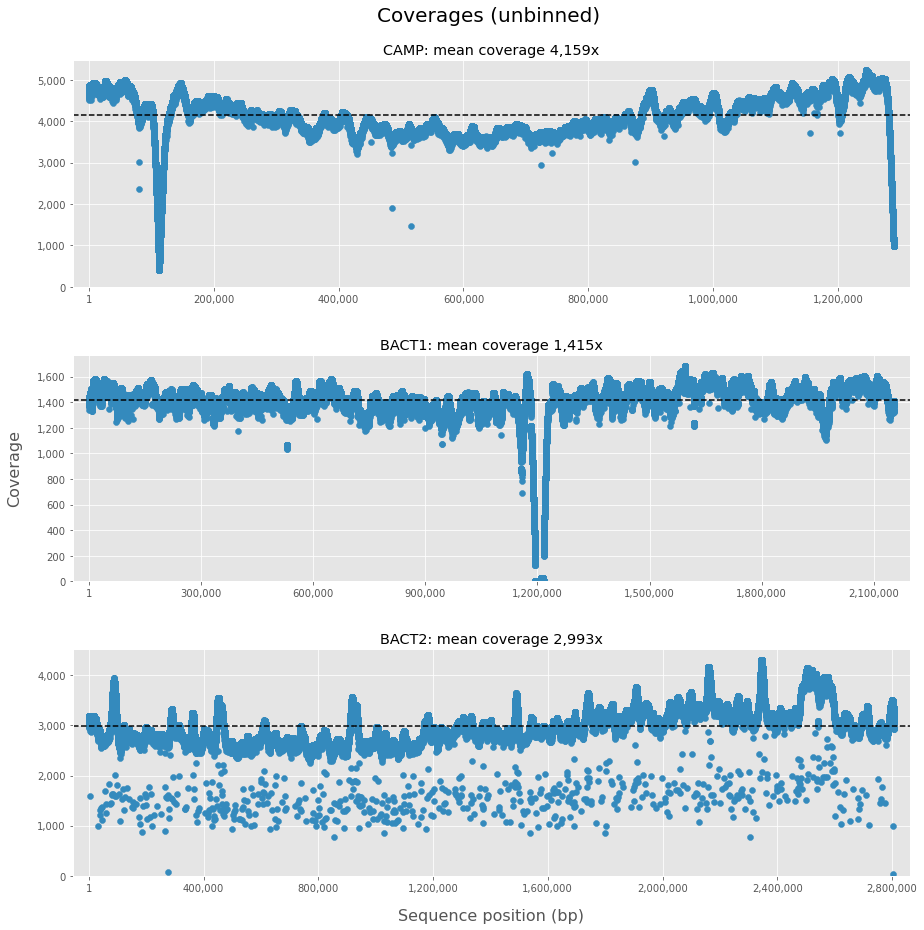

In [55]:
figN, (ax1N, ax2N, ax3N) = pyplot.subplots(3, gridspec_kw={"hspace": 0.3})
coverage_plot("edge_6104", ax1N, show_xlabel=False, show_ylabel=False)
coverage_plot("edge_1671", ax2N, show_xlabel=False, show_ylabel=True, ylabel_fontsize=16)
coverage_plot("edge_2358", ax3N, xlabel_fontsize=16, show_ylabel=False)
figN.set_size_inches(15, 15)
figN.suptitle("Coverages (unbinned)", y=0.93, x=0.51, fontsize=20)
# Remove gratuitous whitespace in saved image: https://stackoverflow.com/a/11847260
figN.savefig("figs/seq-coverage-unbinned.png", bbox_inches="tight")

### Coverages: no binning, including deletions

This proves that most of the outlier low-coverage positions are due to having lots of deletions.

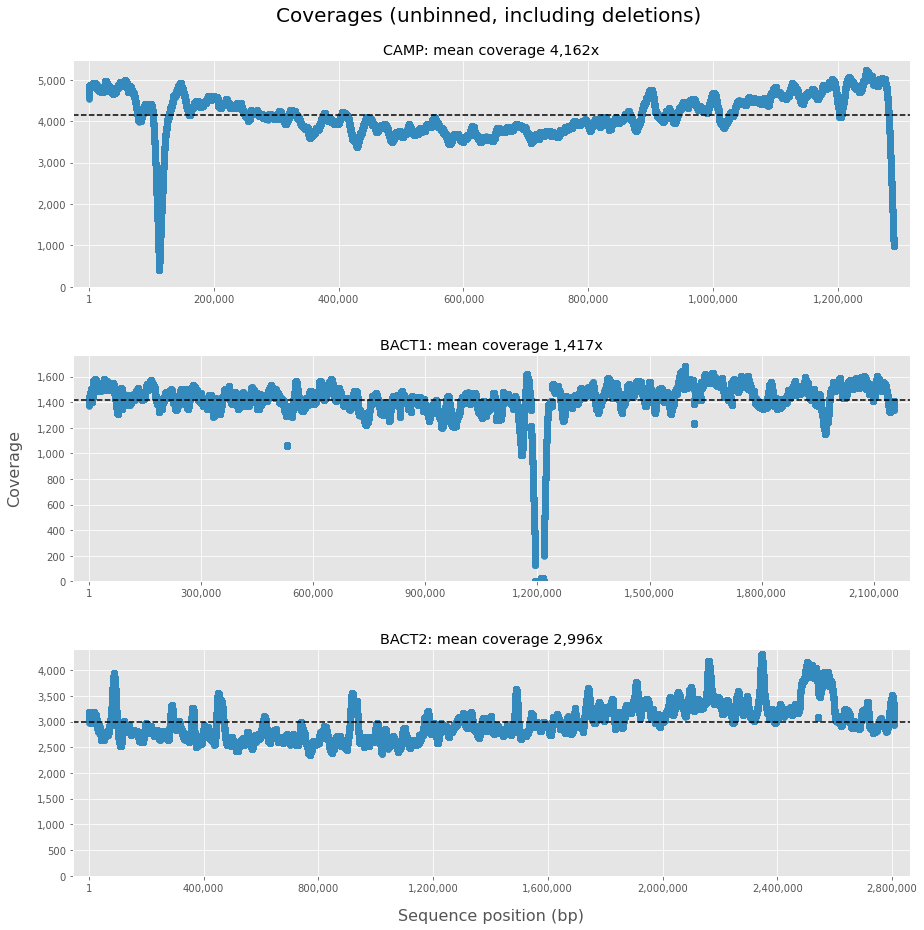

In [56]:
figN, (ax1N, ax2N, ax3N) = pyplot.subplots(3, gridspec_kw={"hspace": 0.3})
coverage_plot("edge_6104", ax1N, show_xlabel=False, show_ylabel=False, incl_deletions=True)
coverage_plot("edge_1671", ax2N, show_xlabel=False, show_ylabel=True, ylabel_fontsize=16, incl_deletions=True)
coverage_plot("edge_2358", ax3N, xlabel_fontsize=16, show_ylabel=False, incl_deletions=True)
figN.set_size_inches(15, 15)
figN.suptitle("Coverages (unbinned, including deletions)", y=0.93, x=0.51, fontsize=20)
figN.savefig("figs/seq-coverage-unbinned-incl-deletions.png", bbox_inches="tight")

### Coverages: with binning every 1 kbp
Subplot stuff based on [the matplotlib docs](https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html) and [this Stack Overflow comment](https://stackoverflow.com/a/35881382) (from which I learned about `gridspec_kw`).

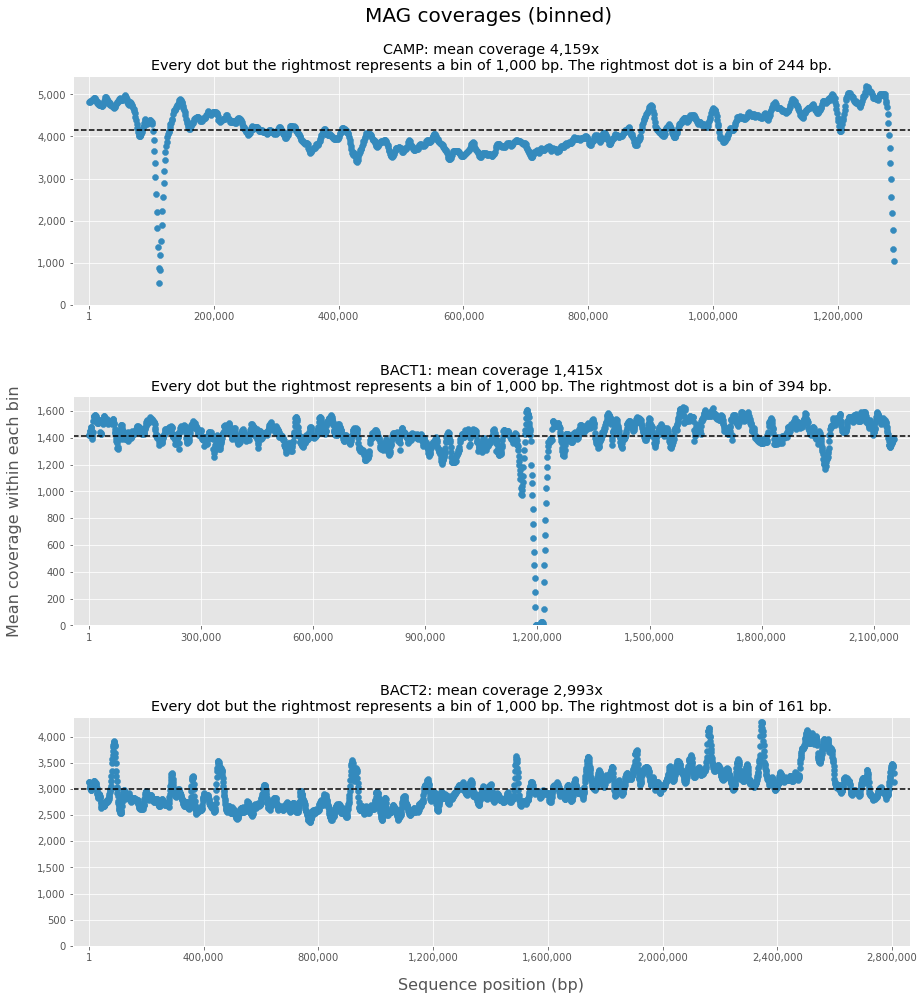

In [9]:
fig, (ax1, ax2, ax3) = pyplot.subplots(3, gridspec_kw={"hspace": 0.4})

smol_binlen = 1000
coverage_plot("edge_6104", ax1, binlen=smol_binlen, show_xlabel=False, show_ylabel=False)
coverage_plot("edge_1671", ax2, binlen=smol_binlen, show_xlabel=False, ylabel_fontsize=16)
coverage_plot("edge_2358", ax3, binlen=smol_binlen, xlabel_fontsize=16, show_ylabel=False)
# Allocate a bit more vertical space, because the titles now each have two rows 
fig.set_size_inches(15, 16)
fig.suptitle("MAG coverages (binned)", y=0.94, x=0.51, fontsize=20)
# Remove gratuitous whitespace in saved image: https://stackoverflow.com/a/11847260
fig.savefig(f"figs/seq-coverage-binned-{smol_binlen}.png", bbox_inches="tight")

### Coverages: larger bins

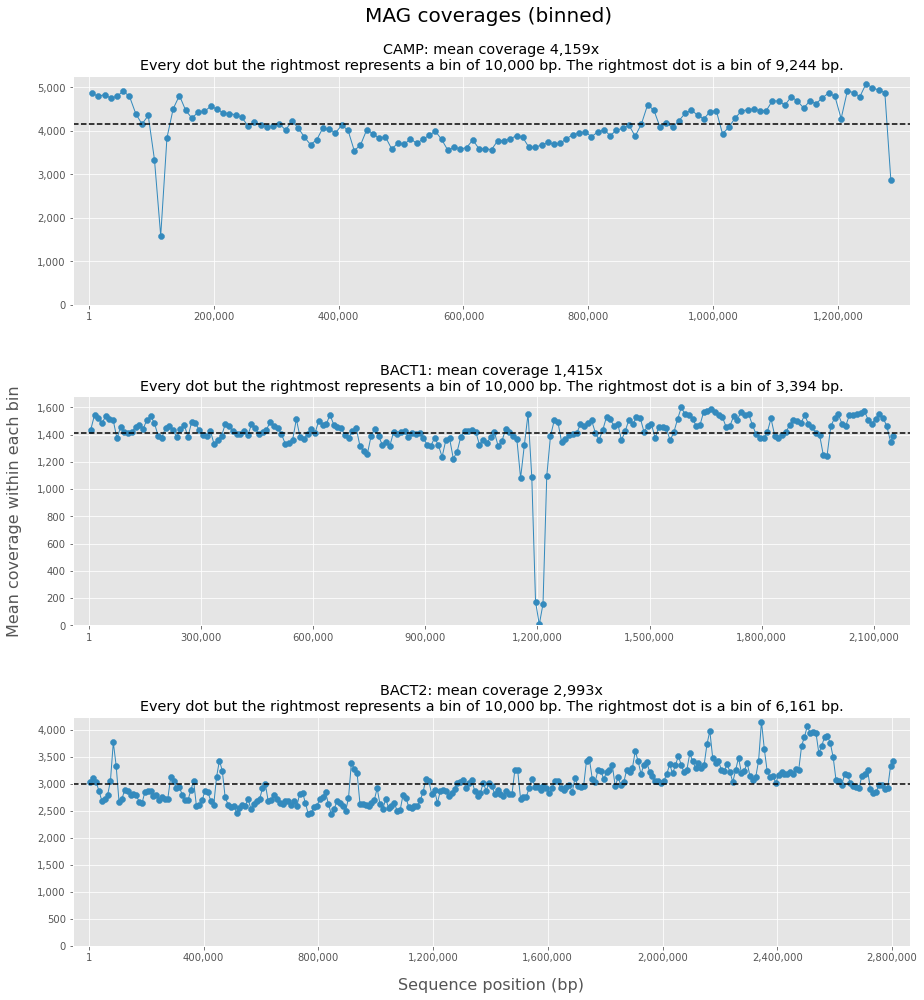

In [23]:
fig, (ax1, ax2, ax3) = pyplot.subplots(3, gridspec_kw={"hspace": 0.4})

lorg_binlen = 10000
kwargs = {"binlen": lorg_binlen, "connect_binpts_by_line": True}
coverage_plot("edge_6104", ax1, show_xlabel=False, show_ylabel=False, **kwargs)
coverage_plot("edge_1671", ax2, show_xlabel=False, ylabel_fontsize=16, **kwargs)
coverage_plot("edge_2358", ax3, xlabel_fontsize=16, show_ylabel=False, **kwargs)

# Allocate a bit more vertical space, because the titles now each have two rows 
fig.set_size_inches(15, 16)
fig.suptitle("MAG coverages (binned)", y=0.94, x=0.51, fontsize=20)
# Remove gratuitous whitespace in saved image: https://stackoverflow.com/a/11847260
fig.savefig(f"figs/seq-coverage-binned-{lorg_binlen}.png", bbox_inches="tight")

## Plot coverage and skew

### Version 1: Don't bin skew

In [84]:
# 1-indexed positions. yeah yeah ideally we'd read in the .sco file and everything rather than hardcoding these
camp_g1217_coords = (1208927, 1210075)
camp_g1217_midpt = mean(camp_g1217_coords)
print(f"CAMP gene 1217's midpoint is at {camp_g1217_midpt:,} bp.")

# "yeah, this gene is gold." -- me, an insane person
gene_highlight_color = "#916c03"

def highlight_g1217(fig, cov_ax, skew_ax):
    cov_ax.axvline(camp_g1217_midpt, linestyle="--", color=gene_highlight_color)
    skew_ax.axvline(camp_g1217_midpt, linestyle="--", color=gene_highlight_color)
    fig.text(x=0.795, y=0.885, s="CAMP Gene 1217", fontsize=10, color=gene_highlight_color, fontweight="semibold")

CAMP gene 1217's midpoint is at 1,209,501 bp.


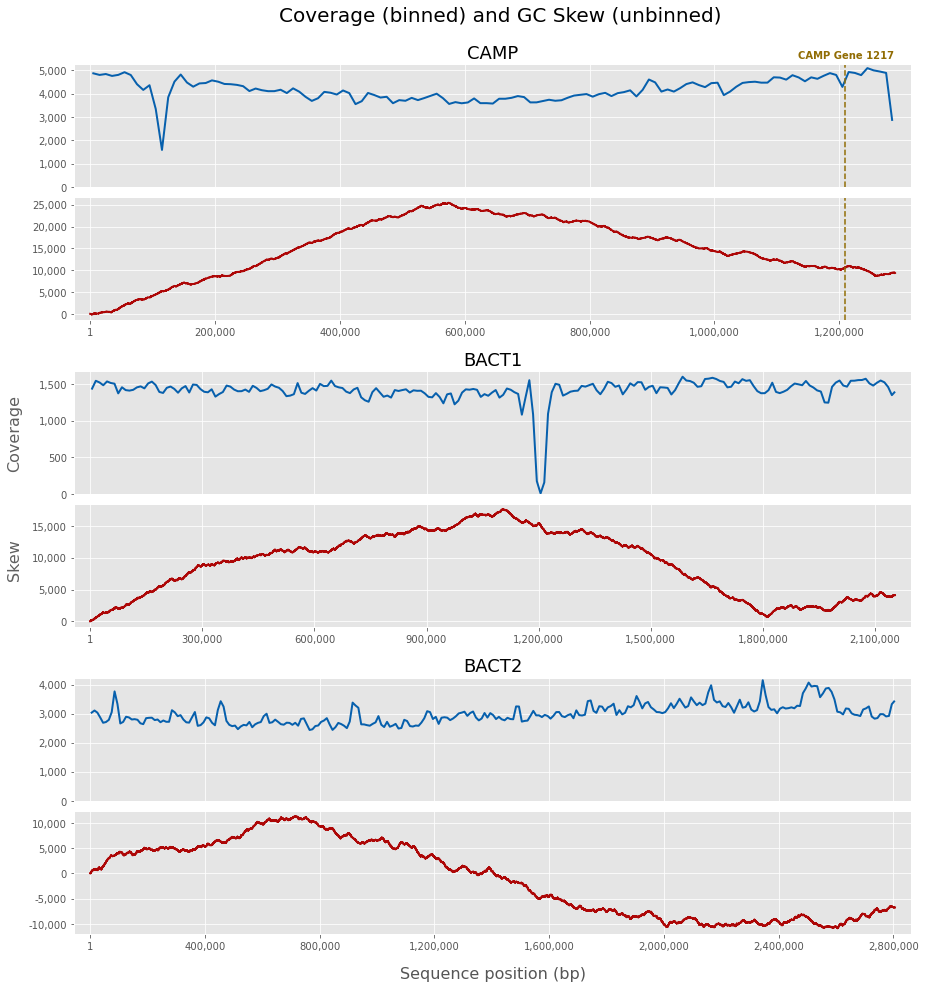

In [86]:
fig, (axc1, axs1, d1, axc2, axs2, d2, axc3, axs3) = pyplot.subplots(
    8, gridspec_kw={
        "hspace": 0.1,
        "height_ratios": [1, 1, 0.25, 1, 1, 0.25, 1, 1]
    }
)

coverage_kwargs = {
    "binlen": 10000,
    "connect_binpts_by_line": True,
    "draw_points": False,
    "show_mean_as_hline": False,
    "show_xlabel": False,
    "show_xticks": False,
    "just_use_seq_as_title": True,
    "make_ylabel_just_coverage": True,
    # dark blue
    "color": "#0760ad",
    "linewidth": 2
}

skew_kwargs = {
    "show_title": False,
    "draw_points": False,
    # dark red
    "color": "#ad0707",
    "linewidth": 2
}

coverage_plot("edge_6104", axc1, show_ylabel=False, **coverage_kwargs)
skew_plot("edge_6104", axs1, show_xlabel=False, show_ylabel=False, **skew_kwargs)
highlight_g1217(fig, axc1, axs1)

coverage_plot("edge_1671", axc2, show_ylabel=False, **coverage_kwargs)
skew_plot("edge_1671", axs2, show_xlabel=False, show_ylabel=False, **skew_kwargs)

coverage_plot("edge_2358", axc3, show_ylabel=False, **coverage_kwargs)
skew_plot("edge_2358", axs3, show_xlabel=True, xlabel_fontsize=16, show_ylabel=False, **skew_kwargs)

# We want to have two relatively large vertical spaces:
#    1. between the top skew and middle coverage plots, and
#    2. between the middle skew and bottom coverage plots.
#
# We *could* make this work by using multiple GridSpec objects (see e.g.
# https://stackoverflow.com/a/31485288), but it's easier to just add in "dummy" axes objects and make
# them invisible. See https://stackoverflow.com/a/53643819.

d1.set_visible(False)
d2.set_visible(False)

# Rather than mess with the individual plots themselves to try to get the middle Coverage and Skew y-axis
# labels to be next to each other, it's easier to just use fig.text() and some trial-and-error to position the
# labels manually. This lets us ensure they're at the exact same x position.
# "No kill like overkill." -- Lobry 1996, probably, idk
yl_kwargs = {
    "rotation": 90,
    "ha": "center",
    "va": "center",
    "fontsize": 16,
    "color": "#606060",
}

fig.text(x=0.07, y=0.56, s="Coverage", **yl_kwargs)
fig.text(x=0.07, y=0.45, s="Skew", **yl_kwargs)

fig.set_size_inches(15, 16)
fig.suptitle("Coverage (binned) and GC Skew (unbinned)", y=0.93, x=0.52, fontsize=20)
# Remove gratuitous whitespace in saved image: https://stackoverflow.com/a/11847260
fig.savefig(f"figs/seq-coverage-binned-and-skews.png", bbox_inches="tight")

### Version 2: Bin skews like coverage

As described in Grigoriev 1998:

> [...] one can use a far more convenient cumulative GC
skew: a sum of (G–C)/(G+C) in adjacent windows from an
arbitrary start to a given point in a sequence. Similar to integration
of the skew function over the DNA length, this value reaches its
global maximum at the E.coli terminus, while the minimum
resides over the replication origin.

At least for these three MAGs, this looks basically identical (if a bit smoother) to the unbinned skew plot.

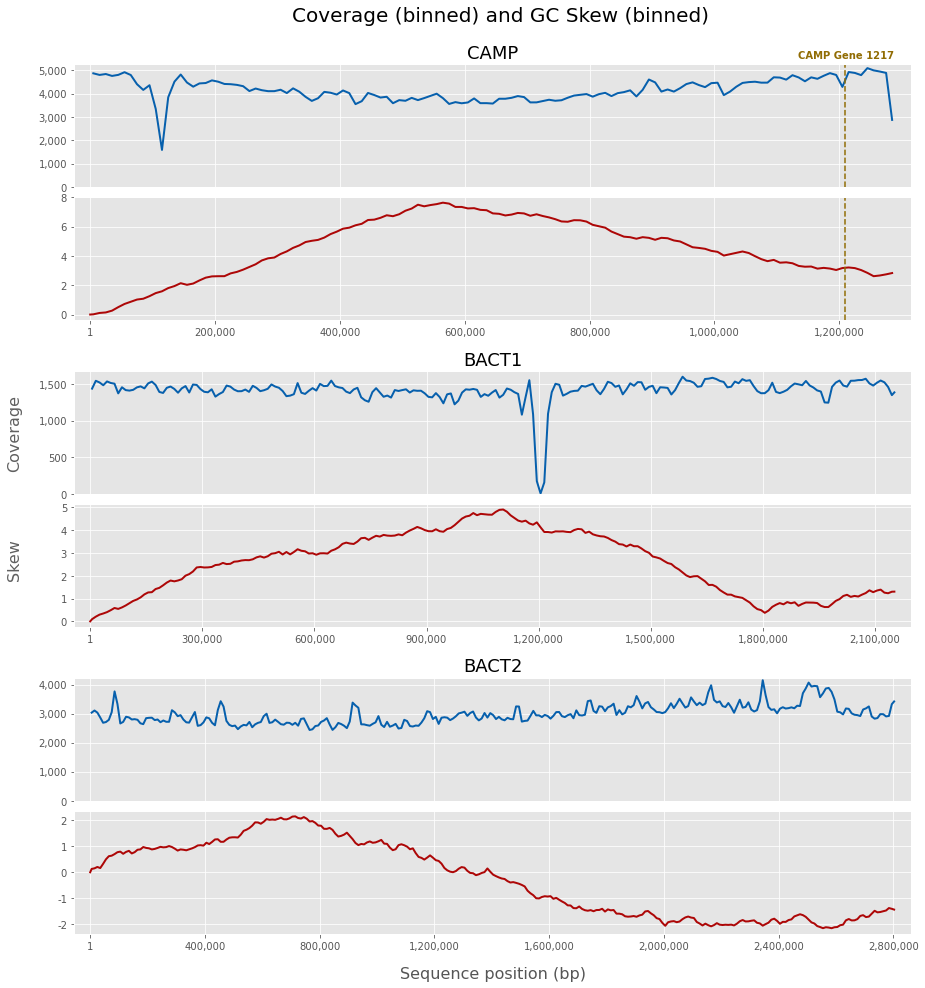

In [85]:
fig, (axc1, axs1, d1, axc2, axs2, d2, axc3, axs3) = pyplot.subplots(
    8, gridspec_kw={
        "hspace": 0.1,
        "height_ratios": [1, 1, 0.25, 1, 1, 0.25, 1, 1]
    }
)

coverage_kwargs_alt = copy.deepcopy(coverage_kwargs)
coverage_kwargs_alt["binlen"] = 10000
skew_kwargs_alt = copy.deepcopy(skew_kwargs)
skew_kwargs_alt["binlen"] = coverage_kwargs_alt["binlen"]

coverage_plot("edge_6104", axc1, show_ylabel=False, **coverage_kwargs_alt)
skew_plot("edge_6104", axs1, show_xlabel=False, show_ylabel=False, **skew_kwargs_alt)
highlight_g1217(fig, axc1, axs1)

coverage_plot("edge_1671", axc2, show_ylabel=False, **coverage_kwargs_alt)
skew_plot("edge_1671", axs2, show_xlabel=False, show_ylabel=False, **skew_kwargs_alt)

coverage_plot("edge_2358", axc3, show_ylabel=False, **coverage_kwargs_alt)
skew_plot("edge_2358", axs3, show_xlabel=True, xlabel_fontsize=16, show_ylabel=False, **skew_kwargs_alt)

d1.set_visible(False)
d2.set_visible(False)

fig.text(x=0.07, y=0.56, s="Coverage", **yl_kwargs)
fig.text(x=0.07, y=0.45, s="Skew", **yl_kwargs)

fig.set_size_inches(15, 16)
fig.suptitle("Coverage (binned) and GC Skew (binned)", y=0.93, x=0.52, fontsize=20)
fig.savefig(f"figs/seq-coverage-binned-and-skews-binned.png", bbox_inches="tight")